In [1]:
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont


def draw_bboxes(
    image_np: np.ndarray,
    bboxes_np: np.ndarray,
    labels_np: np.ndarray,
    color: tuple = (255, 0, 0),
    font_size: int = 16,
    thickness: int = 2,
) -> Image.Image:
    """
    在图像上绘制边界框和标签（支持中文）

    Args:
        image_np (np.ndarray): shape (H, W, 3), dtype uint8
        bboxes_np (np.ndarray): shape (N, 4), xyxy格式, dtype int32
        labels_np (np.ndarray or list): 长度为N的字符串数组或列表
        color (tuple): 边界框和文字颜色，默认红色 (R, G, B)
        font_size (int): 标签字体大小
        thickness (int): 边界框线宽

    Returns:
        Image.Image: 绘制完成的PIL图像
    """
    # 转换为PIL图像
    img = Image.fromarray(image_np)
    draw = ImageDraw.Draw(img)

    # 加载字体（支持中文）
    font_path = "/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc"
    try:
        font = ImageFont.truetype(font_path, font_size)
    except Exception as e:
        print(f"[Warning] Failed to load font {font_path}: {e}, using default font.")
        font = ImageFont.load_default()

    # 转换边界框为 (x1, y1, x2, y2) 格式
    for i, box in enumerate(bboxes_np):
        label = str(labels_np[i])

        x1, y1, x2, y2 = map(int, box)

        # 绘制矩形框
        draw.rectangle([x1, y1, x2, y2], outline=color, width=thickness)

        # 计算文本尺寸
        text_bbox = draw.textbbox((0, 0), label, font=font)
        text_w = text_bbox[2] - text_bbox[0]
        text_h = text_bbox[3] - text_bbox[1]

        # 文本背景区域
        text_bg_rect = [x1, y1 - text_h - 5, x1 + text_w, y1]
        draw.rectangle(text_bg_rect, fill=color)

        # 绘制文本
        draw.text((x1, y1 - text_h - 5), label, fill=(255, 255, 255), font=font)

    return img

def visualize_bbox_datasets(ds, samples=5):
    """Visualizes original image and augmented versions."""
    # Prepare visualization pipeline (strip Normalize, ToTensor)
    figure, ax = plt.subplots(1, samples, figsize=(15, 5))

    # Draw original
    select_idx = np.random.randint(0, len(ds))

    # Draw augmented samples
    for i in range(samples):
        # Apply the visualization transform
        # Ensure labels are passed correctly based on label_fields
        aug_image, meta = ds[select_idx]
        aug_bboxes = meta['boxes'].numpy()
        aug_labels = meta['labels'].numpy()
        augmented_drawn = draw_bboxes(aug_image, aug_bboxes, aug_labels)
        ax[i].imshow(augmented_drawn)
        ax[i].set_title(f"Augmented {i+1}")
        ax[i].axis("off")

    plt.tight_layout()
    plt.show()

/data/16t/wxh/LitDetect/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/16t/wxh/LitDetect/.venv/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of AlbumentationsX (2.0.13) is available! Your version is 2.0.9. Upgrade using: pip install -U albumentationsx
  check_for_updates()


In [2]:
from hydra import compose, initialize
from omegaconf import DictConfig

# ---------------------------------------------------------------------#
#       读取配置文件
# ---------------------------------------------------------------------#
with initialize(version_base=None, config_path="conf"):
    cfg: DictConfig = compose(config_name="config", overrides=["md@run=frcnn_dinov3", "ds@run=nodule"])
    print(cfg)

{'run': {'seed': 172, 'call_back_monitor': 'map_50', 'call_back_mode': 'max', 'csdp': None, 'sdp': None, 'dataset': 'yolo', 'cache_mode': 'disable', 'weight_decay': 0.0001, 'lr': 0.0003, 'lr_scheduler': 'step', 'lr_step_size': 2, 'lr_gamma': 0.99, 'early_stop': True, 'optimizer': 'muon', 'muon_lr': 0.001, 'muon_weight_decay': 0.003, 'model_name': 'faster_rcnn', 'backbone_name': 'convnext_small', 'backbone_type': 'dinov3', 'weights_path': '/data/16t/wxh/ds/ckpts/dinov3_convnext_small_pretrain_lvd1689m-296db49d.pth', 'REPO_DIR': '/data/16t/wxh/dinov3', 'pretrained': True, 'iou_thres': 0.45, 'conf_thres': 0.05, 'input_size_hw': [512, 512], 'train_batch_size': 14, 'val_batch_size': 5, 'num_workers': 16, 'dataset_name': 'LungNodule', 'num_classes': 4, 'class_name': ['Calcified nodule', 'Solid nodule', 'Ground-glass nodule', 'Part-solid nodule'], 'ano_root': '/home/star/deeplearning/LungNodule/datasets/labels', 'image_root': '/home/star/deeplearning/LungNodule/datasets/images'}, 'trainer': {

In [3]:
from litdetect.data import DataInterface
# ---------------------------------------------------------------------#
#       实例化数据集
# ---------------------------------------------------------------------#
dl = DataInterface(**cfg.run)
dl.setup('fit')

In [4]:
# ---------------------------------------------------------------------#
#       删除ToTensor和Normalize
# ---------------------------------------------------------------------#
dl.trainset.transforms = dl.trainset.transforms - A.ToTensorV2 - A.Normalize
dl.valset.transforms = dl.valset.transforms - A.ToTensorV2 - A.Normalize

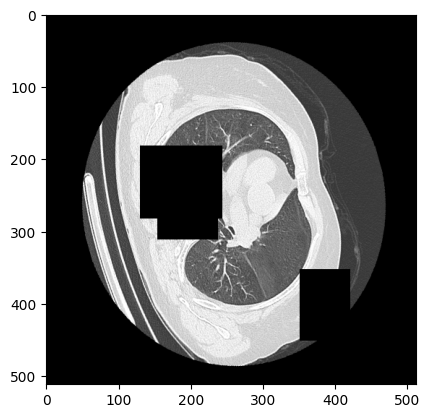

In [5]:
# ---------------------------------------------------------------------#
#       获取数据并绘制
# ---------------------------------------------------------------------#
c = dl.trainset[18]
plt.imshow(c[0])
plt.show()

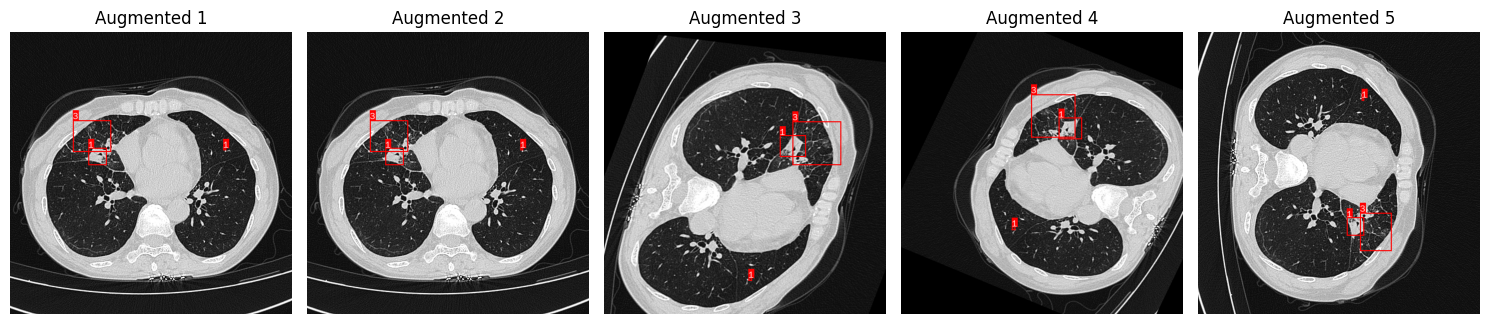

In [6]:
visualize_bbox_datasets(dl.trainset, samples=5)